Here we explore volumetric npy files, that is volumes with dimensions (depth\*height*width).

In [29]:
# Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

config = {
    "num_images": 1024,
    "num_attribs": 7,
    "titles": ['Min Value',
               'Max Value',
               'Average Value',
               'Variation', 
               'Absolute Value Sum',
               'Non-data Region',
               'Entropy'],
    "img_size": (1024, 1024)
}

In [30]:
# Utility functions
def normalize_img(img):
    img = img - np.min(img)
    img = img / np.max(img)
    return img

def clamp_img(img, low=1.0, up=6.0):
    img[img < low] = low
    img[img > up] = up
    return img

def read_raw_to_img(filepath):
    with open(filepath, 'rb') as fid:
        img_data = np.fromfile(fid, dtype=np.float32)
    img = img_data.reshape((1024, 1024))
    return img

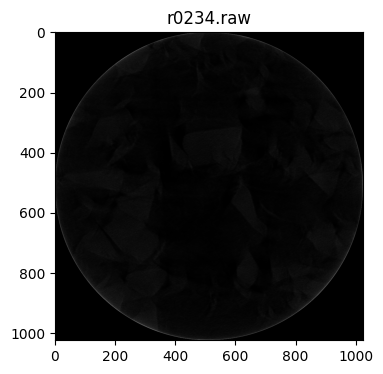

In [32]:
# Read a sample image from dataset, normalize, and display
path_dir = "../data/battery/3_clear/ct_volume/raw"
id = str(np.random.randint(1024)).zfill(4)
name_raw = f"r{id}.raw"
filepath = os.path.join(path_dir, name_raw)
sample = read_raw_to_img(filepath)
sample_norm = normalize_img(sample)

plt.figure(figsize=[4,4])
plt.imshow(sample_norm, cmap='gray')
plt.title(f"{name_raw}")
plt.show()

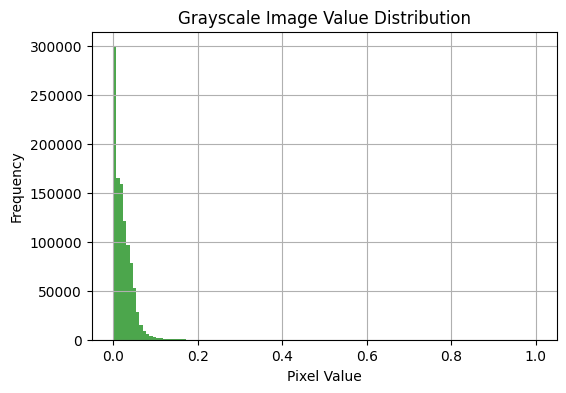

In [33]:
sample_norm = sample_norm.flatten()

plt.figure(figsize=(6, 4))
plt.hist(sample_norm, bins=128, color='green', alpha=0.7, log=False)
plt.title("Grayscale Image Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [34]:
def load_dataset(path, step=1):
    """Load images from directory, resize to img_size
    Return:     images, type numpy, shape (batch, height, width)
    """
    num_images = config["num_images"]
    img_size = config["img_size"]
    num_sub_images = num_images // step
    images = np.zeros((num_sub_images, img_size[0], img_size[1]))

    for i, idx in enumerate(tqdm(range(1, num_images+1, step))):
        filepath = os.path.join(path, f"r{idx:04d}.raw")
        img = read_raw_to_img(filepath)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        images[i] = img

    return images

In [35]:
images = load_dataset(path_dir)
print(f"Images loaded with shape {images.shape}")

100%|██████████| 1024/1024 [00:11<00:00, 86.97it/s] 

Images loaded with shape (1024, 1024, 1024)


## Downsampling

In [36]:
# Assuming `volume` is your original CT volume of shape (1024, 1024, 1024)
def downsample_volume(volume):
    factor = 4  # Downsampling factor (1024/256 = 4)
    return volume.reshape(256, factor, 256, factor, 256, factor).mean(axis=(1, 3, 5))

# Downsampled volume
volume_block = downsample_volume(images)
print(f"volume has shape {volume_block.shape}.")

volume has shape (256, 256, 256).


In [37]:
#volume_block = np.swapaxes(volume_block, 1, 2)
np.save("../data/battery/3_clear/ct_volume/volume_block.npy", volume_block)
print('saved.')

saved.


In [10]:
from scipy.ndimage import zoom

# Assuming `volume` is your original CT volume of shape (1024, 1024, 1024)
def interpolate_volume(volume):
    zoom_factor = 256 / 1024  # Compute the scaling factor
    return zoom(volume, zoom=zoom_factor, order=3)  # Order=3 for cubic interpolation

# Downsampled volume
volume_inter = interpolate_volume(images)
print(f"volume has shape {volume_inter.shape}.")

volume has shape (256, 256, 256).


In [20]:
volume_inter = np.swapaxes(volume_inter, 1, 2)
np.save("../data/battery/3_clear/ct_volume/volume_inter.npy", volume_inter)
print('saved.')

saved.


## Center Crop
We take a central crop in the middle of the volume.

In [10]:
crop_x = 600
crop_y = 600
crop_z = 1024
crop_size = (crop_z, crop_x, crop_y)

# starting indices
start_z = (images.shape[0] - crop_size[0]) // 2
start_x = (images.shape[1] - crop_size[1]) // 2
start_y = (images.shape[2] - crop_size[2]) // 2

# cropping
center_crop = images[
    start_z:start_z + crop_size[0],
    start_x:start_x + crop_size[1],
    start_y:start_y + crop_size[2]
]

print(center_crop.shape)

(1024, 600, 600)


We use bilinear interpolation and resize the images to 256x256. We then take 1 slice every 4 along the batch dimension.

In [12]:
from skimage.transform import resize

volume = np.zeros((256, 256, 256), dtype=center_crop.dtype)

for i in tqdm(range(256)):
    slice_idx = i * 4
    volume[i] = resize(center_crop[slice_idx], (256, 256), anti_aliasing=True, mode='reflect')

print("Final shape:", volume.shape)

100%|██████████| 256/256 [00:02<00:00, 115.75it/s]

Final shape: (256, 256, 256)


In [13]:
np.save("output/600x600/256x256x256.npy", volume)

## Save
In this step we normalize the images.

In [67]:
num_subset_images = images.shape[0]
img_height, img_width = config["img_size"]
norm_images = np.zeros((num_subset_images, img_height, img_width))

for i in tqdm(range(num_subset_images)):
    cloned_image = images[i].copy()
    norm_images[i] = normalize_img(cloned_image)

print(f"Normalized images with shape {norm_images.shape}")

100%|██████████| 256/256 [00:00<00:00, 2224.93it/s]

Normalized images with shape (256, 256, 256)


In [68]:
final_images = norm_images
print(f"final images have shape {final_images.shape}, max is {final_images.max()}, min is {final_images.min()}")

final images have shape (256, 256, 256), max is 1.0, min is 0.0


In [69]:
def save_to_disk(path, images):
    num_images = images.shape[0]

    for i in tqdm(range(num_images)):
        img_path = os.path.join(path, f"id_{i}.jpg")
        img = (images[i] * 255).astype(np.uint8)
        cv2.imwrite(img_path, img)

    print(f"Images savesd in {path}.")

In [70]:
save_dir = "data/denoised/3D_data/normalized_true_ratio"
save_to_disk(save_dir, final_images)

100%|██████████| 256/256 [00:00<00:00, 873.58it/s]

Images savesd in data/denoised/3D_data/normalized_true_ratio.


In [71]:
np.save("output/volume.npy", final_images)

## Create GIF

In [19]:
from PIL import Image
import os

image_folder = "data/denoised/tiff/projections"
output_gif = "data/denoised/tiff/projections/projections.gif"

# Load all images from the folder, assuming they are named in sequential order
images = []
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith(".png"):
        img_path = os.path.join(image_folder, filename)
        images.append(Image.open(img_path))

if images:
    images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)
    print(f"GIF saved as {output_gif}")
else:
    print("No images found in the folder.")

GIF saved as data/denoised/tiff/projections/projections.gif


In [11]:
sorted(os.listdir(image_folder))

['proj_gt_00.png',
 'proj_gt_01.png',
 'proj_gt_02.png',
 'proj_gt_03.png',
 'proj_gt_04.png',
 'proj_gt_05.png',
 'proj_gt_06.png',
 'proj_gt_07.png',
 'proj_gt_08.png',
 'proj_gt_09.png',
 'proj_gt_10.png',
 'proj_gt_11.png',
 'proj_gt_12.png',
 'proj_gt_13.png',
 'proj_gt_14.png',
 'proj_gt_15.png',
 'proj_gt_16.png',
 'proj_gt_17.png',
 'proj_gt_18.png',
 'proj_gt_19.png',
 'proj_gt_20.png',
 'proj_gt_21.png',
 'proj_gt_22.png',
 'proj_gt_23.png',
 'proj_gt_24.png',
 'proj_gt_25.png',
 'proj_gt_26.png',
 'proj_gt_27.png',
 'proj_gt_28.png',
 'proj_gt_29.png',
 'proj_gt_30.png',
 'proj_gt_31.png',
 'proj_gt_32.png',
 'proj_gt_33.png',
 'proj_gt_34.png',
 'proj_gt_35.png',
 'proj_gt_36.png',
 'proj_gt_37.png',
 'proj_gt_38.png',
 'proj_gt_39.png',
 'proj_gt_40.png',
 'proj_gt_41.png',
 'proj_gt_42.png',
 'proj_gt_43.png',
 'proj_gt_44.png',
 'proj_gt_45.png',
 'proj_gt_46.png',
 'proj_gt_47.png',
 'proj_gt_48.png',
 'proj_gt_49.png']

## Comparing volumes

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def hist(data, title='Value Histogram'):
    data_flat = data.flatten()

    plt.figure(figsize=(8, 4))
    plt.hist(data_flat, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


float64
Data shape: (256, 256, 256)


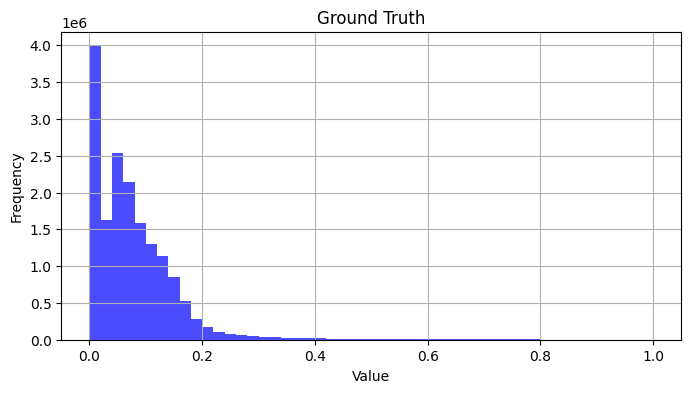

In [33]:
file_path = 'output/volume.npy'
data = np.load(file_path)
print(data.dtype)
print("Data shape:", data.shape)
hist(data, title='Ground Truth')

float64
Data shape: (340, 340, 340)


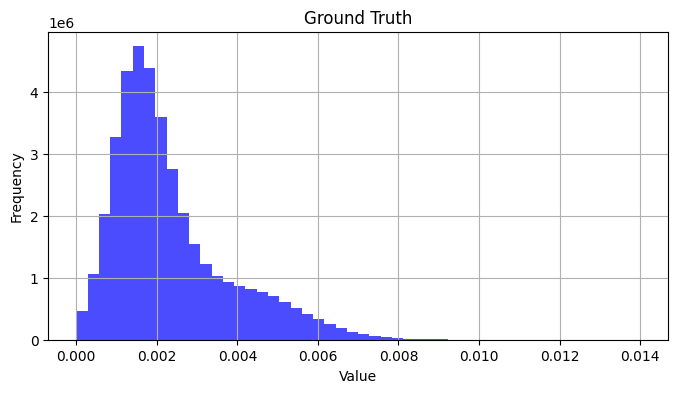

In [32]:
file_path = 'output/crop_340x340x340.npy'
data = np.load(file_path)
print(data.dtype)
print("Data shape:", data.shape)
hist(data, title='Ground Truth')

In [31]:
data.dtype

dtype('float64')

Data shape: (340, 340, 340)


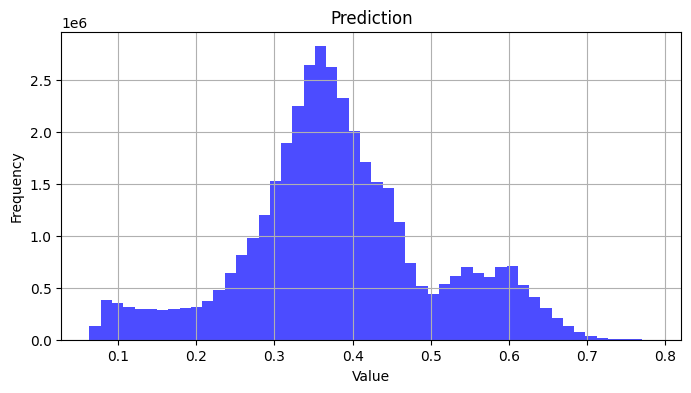

In [23]:
file_path = 'output/crop_340x340x340_pred.npy'
data = np.load(file_path)
print("Data shape:", data.shape)
hist(data, title='Prediction')

In [27]:
data.dtype

dtype('float64')